*Last edit by DLao - 2019*





<br>
<br>


![](http://bathvenuefinder.co.uk/web/wp-content/uploads/2016/02/The-Porter-fine-food.jpg)

# Amazon fine food review - Sentiment analysis

The analysis is to study Amazon food review from customers, and try to predict whether a review is positive or negative. The dataset contains **more than 500K reviews** with number of upvotes & total votes to those comments.

## Table of Content

* Data preparation

* Score prediction
  - Logistic regression model on word count
  - Logistic regression model on TFIDF
  - Logistic regression model on TFIDF + ngram
  
* Upvote prediction
  - Data preview
  - Resampling due to imbalanced data
  - Logistic regression model on word count
  - Logistic regression model on TFIDF + ngram
  - Study on non-context features
  
* In-depth study on user behaviour *(Edit on 2017/10/18)*
  
<br>
I will keep updating this notebook. Feel free to fork and **Upvote** if you find it useful in some ways!

## Data preparation

Let's load some library needed throughout the analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud


Now we load in the dataset and add some columns for upvote metrics:

In [2]:
odf = pd.read_csv('../input/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5,1,'How helpful users find among user scores')

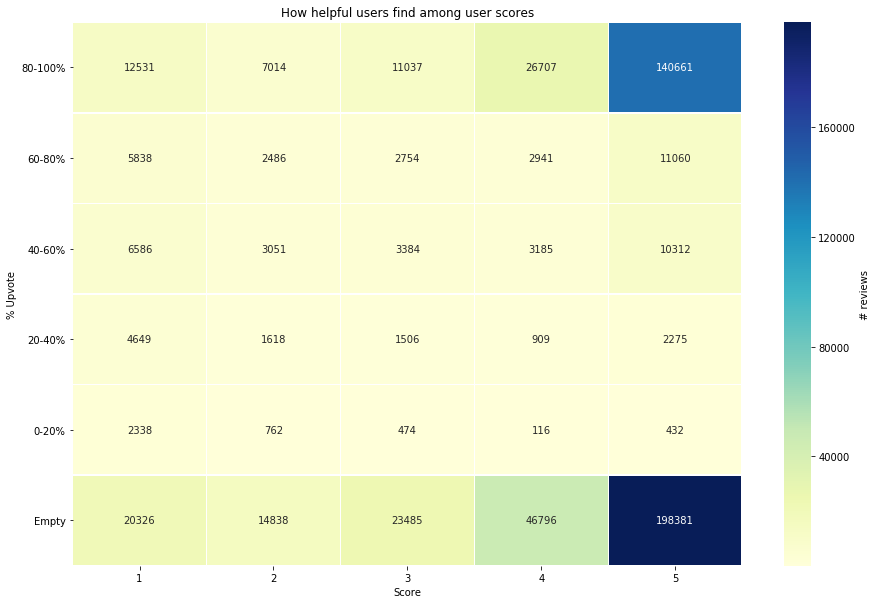

In [3]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:
* Reviews are skewed towards positive
* More than half of the reviews are with zero votes
* Many people agree with score 5 reviews

Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):

In [4]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

## Score prediction
### Logistic regression model on word count

In [5]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.9387162049081809

-Top 20 positive-
Word  Coefficient
   pleasantly     3.329289
emeraldforest     3.207288
      chedder     3.035364
      easiest     2.565063
      solving     2.457934
      blowout     2.453676
     heartier     2.374938
    addicting     2.370847
   unwrapping     2.303204
        herrs     2.302741
       skewed     2.298548
     drawback     2.292735
       hooked     2.290672
       hahaha     2.263889
     downside     2.249939
   correction     2.242783
        whisk     2.198551
       ration     2.192173
       bertie     2.191835
   dishwasher     2.170685

-Top 20 negative-
Word  Coefficient
   unfinished    -2.466344
     tastless    -2.492745
      weakest    -2.602971
    overrated    -2.615756
    cancelled    -2.693055
  unappealing    -2.731129
      furious    -2.745230
   oversalted    -2.753925
    deceptive    -2.821888
disappointing    -2.822668
  undrinkable    -2.826446
  embarrassed    -2.829418
    redeeming    -2.875135


Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [6]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7353142544159934


### Logistic regression model on TFIDF

In [7]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())


# features: 114969
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9346691618360795

-Top 20 positive-
Word  Coefficient
     great    13.722053
 delicious    12.152401
      best    12.013713
   perfect    10.606939
 excellent     9.860665
     loves     9.583115
    highly     9.037667
      love     8.363584
 wonderful     7.965187
   amazing     7.797122
   awesome     7.629256
      good     7.339747
pleasantly     7.242571
      nice     7.188673
    hooked     7.019285
     yummy     6.954306
  favorite     6.941715
   pleased     6.931340
    smooth     6.884071
 fantastic     6.721745

-Top 20 negative-
Word  Coefficient
         waste    -5.624617
          poor    -5.720376
   undrinkable    -5.722118
          yuck    -6.010264
         stale    -6.152055
         worse    -6.281930
         bland    -6.323419
    disgusting    -6.556087
          weak    -6.563156
        return    -6.688471
         threw    -6.733330
     tasteless    -6.838199
 unfortunately    -7.437975
      horrible    -7.793645
         awful    -

Accurancy is roughly the same - 93.5%. However we notice that the significant words make much more sense now, with higher coefficient magnitude as well!

### Logistic regression model on TFIDF + ngram

In [8]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9455398846744869

-Top 20 positive-
Word  Coefficient
           great    21.053000
            best    17.832356
       delicious    17.010372
         perfect    14.621994
           loves    13.611233
            love    13.270458
       excellent    13.142385
            good    11.414094
       wonderful    11.317826
            nice    10.811111
        favorite    10.595136
         amazing     9.691345
         awesome     9.371849
            easy     9.142949
         pleased     8.946003
           happy     8.907161
          smooth     8.714323
           yummy     8.593455
          highly     8.466183
highly recommend     8.423149

-Top 20 negative-
Word  Coefficient
         maybe    -7.808387
        hoping    -8.127677
     tasteless    -8.250498
         money    -8.318603
         worse    -8.352882
       thought    -8.564169
    disgusting    -8.764442
         bland    -9.144472
         threw    -9.304731
         stale    -9.893009
          w

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see "highly recommend" is on 20th place of positive words

## Upvote prediction
### Data preview

This study is to see whether there is pattern found for unpopular (downvote) comments by users (might be used to boost sales).
We will be focusing on score 5 reviews, and get rid of comments with neutral votes:

In [9]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1    151721
0      2707
Name: % Upvote, dtype: int64


The target class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:

In [10]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.ix[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


### Logistic regression model on word count

In [11]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15991
# train records: 4060
# test records: 1354


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.723781388478582

-Top 20 positive-
Word  Coefficient
 fabulous     1.545586
  sitting     1.303502
   sticks     1.237526
  dessert     1.212756
 american     1.154577
   method     1.101325
    close     1.088437
   keurig     1.087050
 cupcakes     1.060573
     nori     1.053990
    value     1.043162
   figure     1.033026
  veggies     1.032414
   stevia     1.014206
   orange     1.002139
    share     0.967894
   second     0.967279
   ginger     0.953972
    keeps     0.950058
reviewers     0.949899

-Top 20 negative-
Word  Coefficient
expiration    -0.969432
     items    -0.970297
   thought    -0.976880
      look    -0.977305
  memories    -0.978421
     gonna    -0.986800
   cereals    -0.989177
     wrong    -1.021175
    nicely    -1.054415
    barley    -1.074731
    reason    -1.127728
    review    -1.151565
     cases    -1.160619
      zico    -1.210817
     stars    -1.258830
   enjoyed    -1.259637
    golden    -1.267455
    lipton    -1.401696


The words look no sense at all, and the coefficients are very small.

### Logistic regression model on TFIDF + ngram

In [12]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 143746
# train records: 4060
# test records: 1354
Model Accuracy: 0.7296898079763663


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



-Top 20 positive-
Word  Coefficient
     food     1.647147
   flavor     1.552531
     just     1.468993
     make     1.337586
     rice     1.291813
    chips     1.273051
  perfect     1.255958
      mix     1.237502
       ve     1.193255
      lot     1.116902
    small     1.113739
      bag     1.024936
   gluten     0.971367
    fresh     0.952015
   stevia     0.938790
  chicken     0.926184
  flavors     0.925472
     teas     0.914433
    tried     0.914180
wonderful     0.912574

-Top 20 negative-
Word  Coefficient
         buy    -0.856383
        item    -0.857375
      reason    -0.862550
        wish    -0.895996
        yoga    -0.908312
     service    -0.941306
      seller    -0.953005
      thanks    -0.953351
great coffee    -0.964508
      lipton    -1.006090
  cappuccino    -1.007144
       order    -1.099343
      coffee    -1.103042
      marley    -1.165078
        know    -1.165885
        zico    -1.217793
     product    -1.471038
          br    -1.68081

Similar to count metric, the accuracy isn't very high and words are not meaningful.

### Study on non-context features

Let's look at some examples of upvote and downvote comments:

In [13]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
343325    My two cats will eat anything. So why do I eve...
100077    This Korean-style ramen is one of my favorites...
103044    I ordered this to serve at a "tea" where I was...
313262    My family and I enjoy Wheat Thins and compared...
144992    Although it may seem just a tad precious, our ...
Name: Text, dtype: object


Time to extract some possible features:

In [14]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']


% Upvote                  0          1
word_count        83.927226  88.634651
capital_count     19.252678  13.878463
question_mark      0.180273   0.076468
exclamation_mark   0.906169   0.958256
punctuation       22.482822  19.701884


Now we train the model to predict:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5945347119645494


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM accuracy: 0.6506646971935007


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

## In-depth study on user behaviour

This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on. 

First let's look at how many reviews each user gave in the past:

In [16]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))


                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

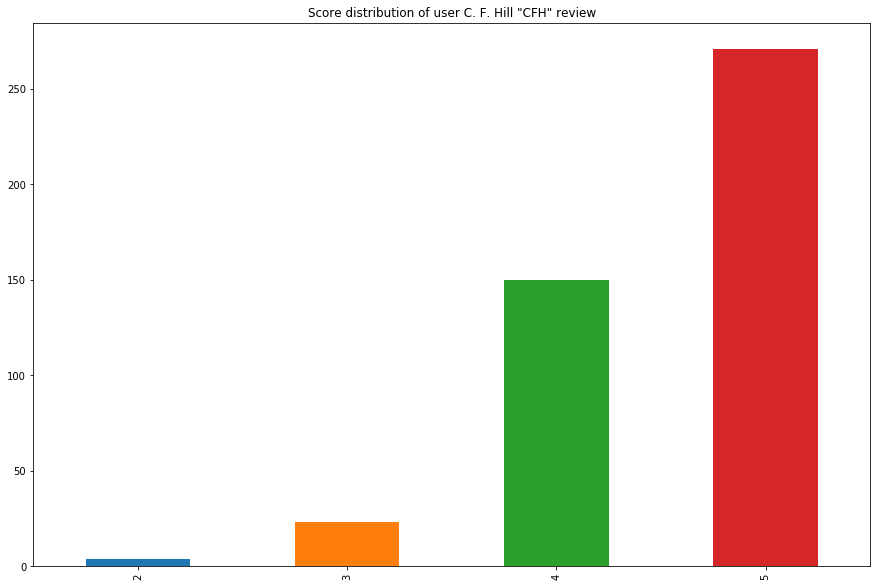

In [17]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that:

In [18]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Bennett seems a good target:

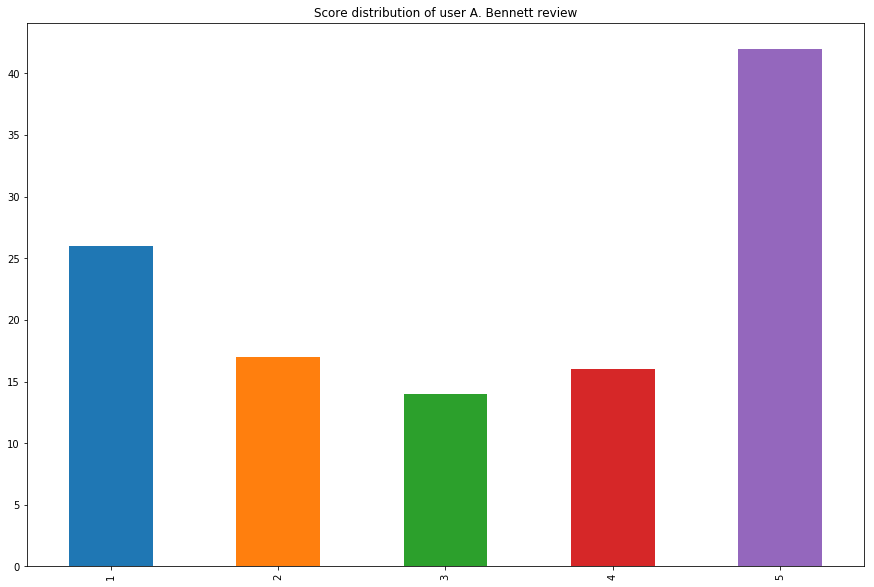

In [19]:
plot_user('A2M9D9BDHONV3Y')

He seems like a better analysis target! Now let's dig deep into his reviews:

In [20]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)



score 1 reviews most popular 2-gram / 3-gram:
   Count  Occur %                   Phrase
0   31.0  119.23%               (..., ...)
1   17.0   65.38%          (..., ..., ...)
2   11.0   42.31%             (never, buy)
3    9.0   34.62%           (buy, product)
4    8.0   30.77%  (monosodium, glutamate)
5    8.0   30.77%    (never, buy, product)
6    7.0   26.92%            (decide, try)
7    7.0   26.92%         (dry, tasteless)
8    7.0   26.92%          (picture, look)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%  (sauce, ruin, whole)
1     8.0  47.06%         (ruin, whole)
2     8.0  47.06%         (sauce, ruin)
3     6.0  35.29%       (product, ever)
4     6.0  35.29%            (n't, buy)
5     5.0  29.41%          (get, wrong)
6     5.0  29.41%          (..., .give)
7     5.0  29.41%    (.give, try, like)
8     5.0  29.41%     (buy, particular)
9     5.0  29.41%     (n't, get, wrong)
10    5.0  29.41%         (taste, like

Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.

Let's look at full picture now instead of just one user:

In [21]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5536.0  10.59%   (taste, like)
1  2316.0   4.43%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1644.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   910.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3237.0   7.59%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1551.0   3.64%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1295.0   

Funny that people are more likely to attach HTML links (href=) for more positive reviews (3 and 4).
<br>
Other than that, not much useful discoveries except positive / negative tones, since people are very different in texting style. 
<br>
Maybe we should focus on popular single **adjective** word people used for different score. First we modify the function a bit for easier implementation:

In [22]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

Let's look at user A. Bennett again:

In [23]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%        bad
3   10.0  38.46%     little
4    8.0  30.77%  expensive
5    8.0  30.77%  delicious
6    8.0  30.77%       hard
7    8.0  30.77%      tasty
8    7.0  26.92%      bread
9    7.0  26.92%       poor
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%       wrong
3    6.0  35.29%   delicious
4    6.0  35.29%       awful
5    5.0  29.41%        good
6    5.0  29.41%       .give
7    5.0  29.41%  particular
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%          good
3    4.0  28.57%  disappointed
4    4.0  28.57%         first
5    4.0  28.57%         great
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0 

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
<br>
Let's also look at big picture:

In [24]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16185.0  30.97%          good
1   10777.0  20.62%           bad
2    4977.0   9.52%         great
3    4844.0   9.27%          much
4    4786.0   9.16%        little
5    4774.0   9.13%           old
6    4198.0   8.03%         first
7    3956.0   7.57%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3537.0   6.77%         small
11   3296.0   6.31%          real
12   3000.0   5.74%  disappointed
13   2884.0   5.52%          sure
14   2831.0   5.42%          free
15   2823.0    5.4%          diet
16   2761.0   5.28%          high
17   2658.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13519.0  45.41%          good
1    4251.0  14.28%          much
2    4169.0   14.0%           bad
3    3909.0  13.13%         great
4    3691.0   12.4%        little
5    2847.0   9.56%         small
6    2323.0    7.8%     

Appreciate any comments!

Hope it is a fun read!